# Import

In [2]:
import numpy as np
import datetime as datetime
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os

# Setup

In [3]:
def collect_data(assets: list, start: datetime.datetime, end: datetime.datetime, path="binance_1m",step='1m',quote_asset="USDT") -> None:
    """
    Collects and saves historical market data for specified assets in CSV files.

    Parameters:
    - assets (list): List of asset symbols to collect data for.
    - start (datetime.datetime): Start date and time for data collection.
    - end (datetime.datetime): End date and time for data collection.
    - path (str): Path to the directory where CSV files will be saved. Default is "binance_1m".
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)

    # Loop through each asset and collect data
    for asset in assets:
        df = get_data(asset, start, end,step,quote_asset)
        full_path = path + '/' + asset + '.csv'
        df.index = pd.to_datetime(df.index)
        df = df[~df.index.duplicated(keep='first')]
        df.to_csv(full_path)

def get_data(asset: str, start: datetime.datetime, end: datetime.datetime, step: str, quote_asset:str) -> pd.DataFrame:
    """
    Retrieves historical market data for a specific asset.

    Parameters:
    - asset (str): Symbol of the asset.
    - start (datetime.datetime): Start date and time for data collection.
    - end (datetime.datetime): End date and time for data collection.
    - step (int): Time interval for data points.
    - quote_asset (str): Quote asset symbol. Default is "USDT".

    Returns:
    - pd.DataFrame: DataFrame containing historical market data.
    """
    res = []
    limit = 1000
    start_time = start

    # Collect data in chunks of 'limit' hours until the end time is reached
    while start_time < end + datetime.timedelta(minutes=limit):
        end_time = start_time + datetime.timedelta(minutes=limit)
        res += data_call(asset, quote_asset, step, start_time, end_time, limit)
        start_time = end_time

    # Collect remaining data until the specified end time
    end_time = end
    res += data_call(asset, quote_asset, step, start_time, end_time, limit)

    return pd.DataFrame(data=res, columns=["Close", "Time"]).set_index("Time")

def data_call(asset: str, quote_asset: str, step: int, start_time: datetime.datetime, end_time: datetime.datetime, limit: int) -> list:
    """
    Makes API call to Binance to retrieve historical market data.

    Parameters:
    - asset (str): Symbol of the asset.
    - quote_asset (str): Quote asset symbol.
    - step (int): Time interval for data points.
    - start_time (datetime.datetime): Start date and time for data collection.
    - end_time (datetime.datetime): End date and time for data collection.
    - limit (int): Maximum number of data points per API call.

    Returns:
    - list: List of lists containing historical market data.
    """
    url = 'https://api.binance.com/api/v3/klines?symbol=' + asset + quote_asset + '&interval=' + str(step) + '&startTime=' + str(int(start_time.timestamp())) + '000' + '&endTime=' + str(int(end_time.timestamp())) + '000&limit=' + str(limit)
    data = requests.get(url).json()
    return extract_data(data)

def extract_data(data):
    """
    Extracts relevant data from the API response.

    Parameters:
    - data: API response containing raw market data.

    Returns:
    - list: List of lists containing relevant market data.
    """
    res = []
    for obj in data:
        date = datetime.datetime.fromtimestamp(int(str(obj[6])[:-3]) + 1)
        close_price = obj[4]
        res.append([close_price, date])
    return res

def load_data(assets: list, start: datetime.datetime, end: datetime.datetime, fields="Close", path="binance_1m"):
    """
    Load historical market data from CSV files for specified assets and time range.

    Parameters:
    - assets (list): List of asset symbols to load data for.
    - start (datetime.datetime): Start date and time for data loading.
    - end (datetime.datetime): End date and time for data loading.
    - fields (list): List of fields to include in the loaded data. Default is ["Close"].
    - path (str): Path to the directory where CSV files are stored. Default is "binance_1m".

    Returns:
    - pd.DataFrame: DataFrame containing loaded historical market data for specified assets and fields.
    """
    data = {}

    # Iterate through each asset and load data
    for asset in assets:
        # Read CSV file and set the "Time" column as the index
        obj = pd.read_csv(path + '/' + asset + '.csv').set_index("Time")

        # Keep only specified fields
        obj = obj[fields]
        
        # Convert the index to datetime format
        obj.index = pd.to_datetime(obj.index)

        # Filter data for the specified time range
        obj = obj.loc[start:end]

        # Drop any rows with missing values
        obj = obj.dropna()

        # Store the loaded data in the 'data' dictionary
        data[asset] = obj

    # Create a DataFrame from the 'data' dictionary
    return pd.DataFrame(data=data)
    

In [4]:
assets = ["BTC","ETH","BNB","XRP","ADA","LTC","SOL","UNI","AAVE","LINK","MKR","FTM","EOS","SAND","XTZ","TRX"]

In [5]:
len(assets)

16

In [ ]:
# Download Data (can takes few mintutes)
start=datetime.datetime(2022, 1, 2 ,0, 0, 0, 0) 
end=datetime.datetime(2022, 3, 2 ,0, 0, 0, 0)
collect_data(assets,start,end)

In [7]:
# Load Local Data
data = load_data(assets,start,end)
data

,BTC,ETH,BNB,XRP,ADA,LTC,SOL,UNI,AAVE,LINK,MKR,FTM,EOS,SAND,XTZ,TRX
Time,,,,,,,,,,,,,,,,
2022-01-02 00:01:00,47426.55,3755.99,525.5,0.8473,1.371,150.0,177.26,17.28,261.6,20.43,2395.0,2.5170,3.109,5.9281,4.713,0.07630
2022-01-02 00:02:00,47347.98,3750.60,525.1,0.8464,1.365,149.7,177.08,17.27,260.8,20.37,2392.0,2.5120,3.102,5.9202,4.708,0.07625
2022-01-02 00:03:00,47349.45,3751.32,525.1,0.8460,1.365,149.7,177.21,17.25,260.6,20.39,2394.0,2.5111,3.105,5.9204,4.711,0.07627
2022-01-02 00:04:00,47344.65,3753.85,525.0,0.8464,1.367,149.7,177.26,17.26,260.6,20.43,2395.0,2.5136,3.105,5.9237,4.705,0.07625
2022-01-02 00:05:00,47342.95,3750.86,525.3,0.8467,1.367,149.7,177.17,17.26,260.7,20.43,2395.0,2.5149,3.106,5.9248,4.704,0.07624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 23:56:00,44122.33,2963.78,407.3,0.7863,0.962,111.9,97.72,10.27,142.6,15.24,1967.0,1.8276,2.256,3.3396,3.471,0.06180
2022-03-01 23:57:00,44171.80,2970.44,408.1,0.7874,0.963,112.2,97.94,10.29,143.1,15.29,1969.0,1.8305,2.261,3.3456,3.478,0.06187
2022-03-01 23:58:00,44169.21,2973.05,408.2,0.7872,0.963,112.0,97.90,10.29,143.1,15.29,1969.0,1.8320,2.262,3.3456,3.478,0.06190


In [8]:
lag = 240
i = 10000
x_array = np.array(data.iloc[i:i+lag])
x_array = x_array/x_array[0]

# Linear Regression

In [9]:
def lin_regression_weights(X: np.ndarray, Y: np.ndarray):
    """
    Computes the weights for linear regression using the normal equation.

    Parameters:
    - X: np.ndarray, shape (m, n)
      The input feature matrix with m examples and n features.
    - Y: np.ndarray, shape (m, n)
      The target values.

    Returns:
    - weights: np.ndarray, shape (n, n)
      The computed weights for linear regression.
    """

    # Calculate the dot product of the transpose of X and X
    X_transpose_X = np.dot(X.T, X)

    # Calculate the inverse of X_transpose_X
    X_transpose_X_inv = np.linalg.inv(X_transpose_X)

    # Calculate the dot product of X_transpose_X_inv and the transpose of X
    X_inv_X_transpose = np.dot(X_transpose_X_inv, X.T)

    # Calculate the final dot product to get the weights
    weights = np.dot(X_inv_X_transpose, Y)

    return weights

In [10]:
w = lin_regression_weights(x_array,x_array)

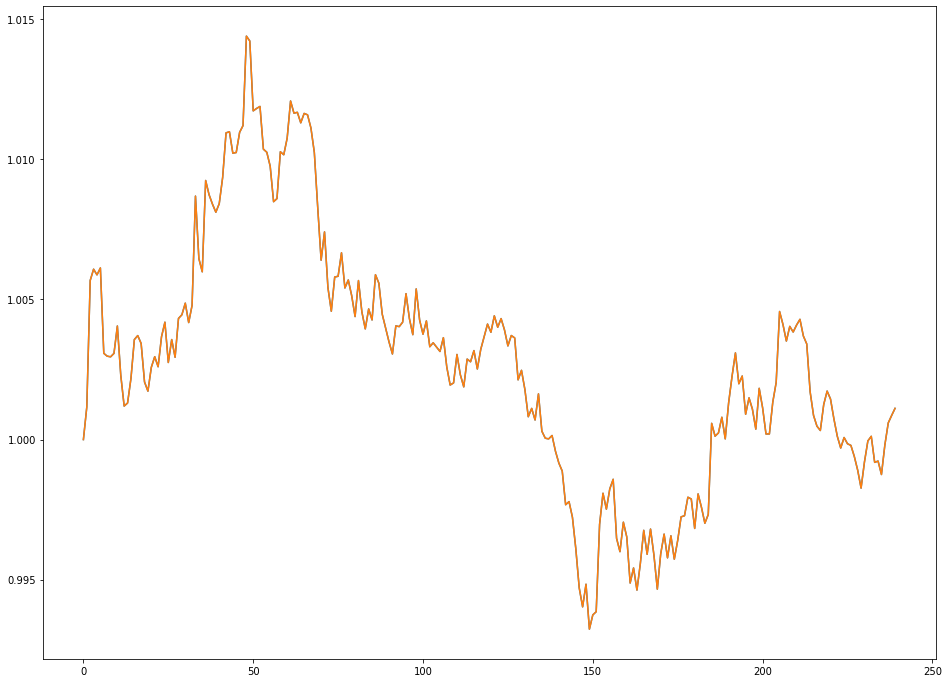

In [11]:
dims = (16,12)
k = 0
fig = plt.subplots(figsize=dims)
plt.plot(x_array[:,k])
plt.plot(x_array@w[k])
plt.show()

In [12]:
print(np.round(w,6))

[[ 1.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.]
 [-0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0. -0.  1. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0.]
 [ 0. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.  1. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -0. -0.  0.  0. -0.  0.  1.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0. -0.  0. -0.  0.  1.  0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  1. -0. -0. -0. -0. -0.]
 [-0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  1.  0.  0. -0.  0.]
 [ 0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  1.  0.  0.  0.]
 [-0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -0.  0.]
 [ 0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  1. 

# Ridge Regression 

In [13]:
def ridge_regression_weights(X: np.ndarray, Y: np.ndarray, lambda_=0.001):
    """
    Computes the weights for ridge regression using the Ridge Regression formula.

    Parameters:
    - X: np.ndarray, shape (m, n)
      The input feature matrix with m examples and n features.
    - Y: np.ndarray, shape (m, n)
      The target values.
    - lambda_: float, optional (default=0.001)
      The regularization strength.

    Returns:
    - weights: np.ndarray, shape (n, n)
      The computed weights for ridge regression.
    """

    # Calculate the dot product of the transpose of X and X
    X_transpose_X = np.dot(X.T, X)

    # Calculate the regularization term (alpha * identity matrix)
    regularization_term = lambda_ * np.eye(X.shape[1])

    # Add the regularization term to X_transpose_X
    X_transpose_X_regularized = X_transpose_X + regularization_term

    # Calculate the inverse of the regularized term
    X_transpose_X_inv = np.linalg.inv(X_transpose_X_regularized)

    # Calculate the dot product of X_transpose_X_inv and the transpose of X
    X_inv_X_transpose = np.dot(X_transpose_X_inv, X.T)

    # Calculate the final dot product to get the weights
    weights = np.dot(X_inv_X_transpose, Y)

    return weights

In [15]:
w = ridge_regression_weights(x_array,x_array,lambda_ = 0.001)

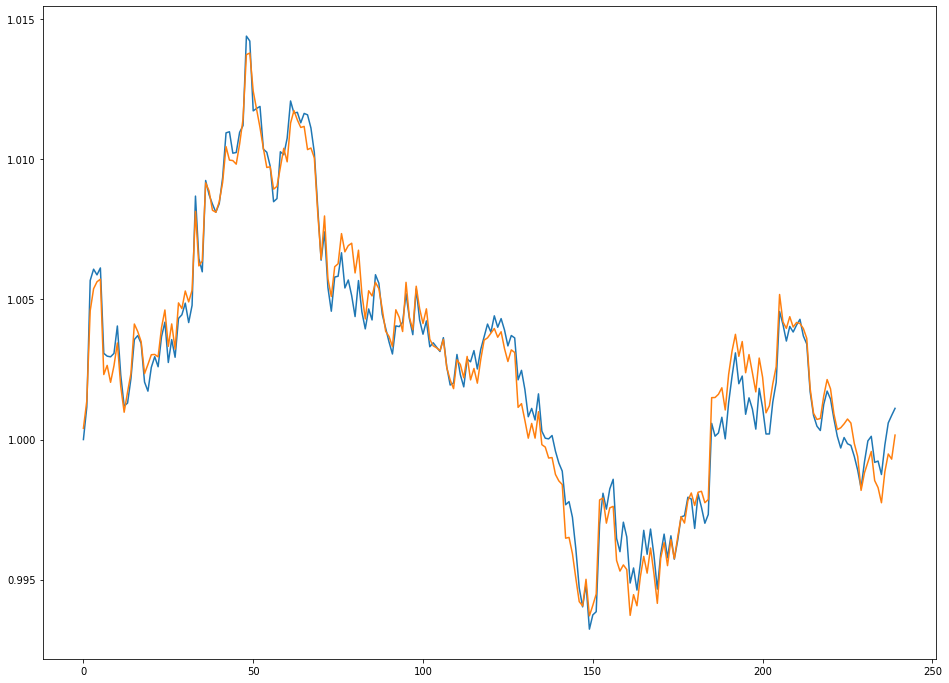

In [16]:
dims = (16,12)
k = 0
fig = plt.subplots(figsize=dims)
plt.plot(x_array[:,k])
plt.plot(x_array@w[k])
plt.show()

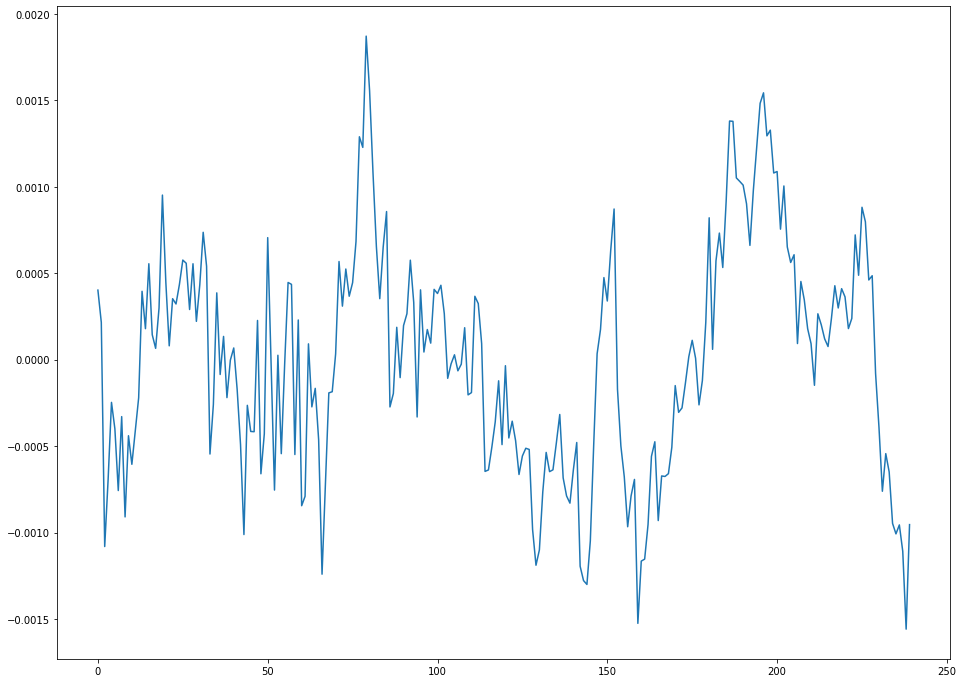

In [96]:
fig = plt.subplots(figsize=dims)
plt.plot(x_array@w[k]-x_array[:,k])
plt.show()